In [1]:
import os
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
import seaborn as sns

In [2]:
# Set the seeds for reproducibility
seed = 2024
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [14]:
# Set the height and width for the whole dataset
image_width = 224 # pixel
image_height = 224 # pixel
# Set the maximum sequence length
sequence_length = 16 # frames
# Dropout value
dropout_value = 0.3
lstm_cells = 128
# Flag to save the model
save_flag = False
# Dataset directory
dataset_dir = 'dataset\\ToyDataset'
classes = os.listdir(dataset_dir)

In [4]:
def get_frames(video_path, sequence_length=20, image_width=64, image_height=64):
    '''
    Function that extracts the frames from the provided videos
    
    Args:
        video_path (str): path to the video
        sequence_length (int): length of the sequences of frames
        image_width (int): width in pixels
        image_height (int): height in pixels
    Returns:
        frames (list[np.array]): list of frames in the video
    '''
    
    frames = []
    
    cap = cv2.VideoCapture(video_path)
    # Check if caption opened successfully 
    if (cap.isOpened()== False): 
        print(f"Error opening {video_path}!")
    
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # Compute the interval for the division of the videos to extract only n frames from the video
    frame_window = max(math.floor(total_frames/sequence_length),1)
    
    for f_idx in range(sequence_length):
        # Set the position of the frame we want
        cap.set(cv2.CAP_PROP_POS_FRAMES, f_idx*frame_window)
        success, frame = cap.read()
        if not success:
            break
        # Frame pre-processing (resizing, normalization)
        resized_frame = cv2.resize(frame, (image_height, image_width))
        resized_frame = resized_frame/255
        
        frames.append(resized_frame)
    
    cap.release()
    
    return frames

In [5]:
def dataset_extraction(dataset_dir, classes, sequence_length, image_width, image_height):
    '''
    Function that creates the dataset starting from the data of the toy dataset
    
    Args:
        dataset_dir (str): path to the dataset
        classes (list[str]): list of classes which correspond to the folders in the dataset
        sequence_length (int): length of the sequences of frames
        image_width (int): width in pixels
        image_height (int): height in pixels
    Returns:
        frame_lists (np.array): list of collection of frames
        labels (np.array): list of labels for the videos
        paths (list): list of filenames of the videos
    '''
    frame_lists = []
    labels = []
    paths = []
    
    for cl_idx, cl in enumerate(classes):
        cl_videos = os.listdir(os.path.join(dataset_dir,cl))
        for filename in cl_videos:
            fullpath = os.path.join(dataset_dir,cl,filename)
            frames = get_frames(fullpath, sequence_length, image_width, image_height)
            if len(frames) == sequence_length:
                frame_lists.append(frames)
                labels.append(cl_idx)
                paths.append(fullpath)
                
    frame_lists = np.array(frame_lists)
    labels = np.array(labels)
    
    return frame_lists, labels, paths
    

In [15]:
frame_lists, labels, paths = dataset_extraction(dataset_dir, classes, sequence_length, image_width, image_height)

In [16]:
# Create one-hot encoding for the labels
coded_labels = to_categorical(labels)

In [17]:
# Divide the dataset into training and test
frame_train, frame_test, label_train, label_test = train_test_split(frame_lists, coded_labels, test_size=0.25, shuffle=True, random_state=seed)

In [18]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(image_width, image_height, 3),
    trainable=False
)

In [11]:
time_layer = TimeDistributed(feature_extractor_layer)

In [19]:
feature_batch = feature_extractor_layer(frame_train[0][0])
print(feature_batch.shape)

ValueError: Exception encountered when calling layer "keras_layer_1" "                 f"(type KerasLayer).

Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (4 total):
    * <tf.Tensor 'inputs:0' shape=(224, 224, 3) dtype=float32>
    * False
    * False
    * 0.99
  Keyword arguments: {}

 Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (4 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    * True
    * False
    * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
  Keyword arguments: {}

Option 2:
  Positional arguments (4 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    * True
    * True
    * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
  Keyword arguments: {}

Option 3:
  Positional arguments (4 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    * False
    * True
    * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
  Keyword arguments: {}

Option 4:
  Positional arguments (4 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    * False
    * False
    * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
  Keyword arguments: {}

Call arguments received by layer "keras_layer_1" "                 f"(type KerasLayer):
  • inputs=tf.Tensor(shape=(224, 224, 3), dtype=float32)
  • training=None

Long-term Recurrent Convolutional Network for Visual Recognition and Description

In [9]:
def LRCN():
    '''
    Function that creates the LRCN model decribed in the paper above
    
    Returns:
        model: the initialized model
    '''
    # Layers layout
    model = Sequential()
    
    # Specify input shape
    model.add(Input(shape=(sequence_length, image_height, image_width, 3)))
    
    # Add the layers to the network
    model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4,4))))
    model.add(TimeDistributed(Dropout(dropout_value)))
    
    model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4,4))))
    model.add(TimeDistributed(Dropout(dropout_value)))
    
    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2,2))))
    model.add(TimeDistributed(Dropout(dropout_value)))
    
    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2,2))))
    # Create the feature vector
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(lstm_cells))
    model.add(Dense(len(classes), activation='softmax'))
    
    model.summary()
    
    return model

In [10]:
model = LRCN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 128, 128, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 32, 32, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 32, 32, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 32, 32, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 8, 8, 32)     0

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min',restore_best_weights=True)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
train_history = model.fit(x=frame_train, y=label_train, epochs=70, batch_size=4,
                          shuffle=True,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/70
13/13 [==============================] - 11s 564ms/step - loss: 1.1200 - accuracy: 0.5385 - val_loss: 1.0473 - val_accuracy: 0.6429
Epoch 2/70
13/13 [==============================] - 5s 398ms/step - loss: 1.0660 - accuracy: 0.5385 - val_loss: 1.0792 - val_accuracy: 0.6429
Epoch 3/70
13/13 [==============================] - 4s 325ms/step - loss: 1.0183 - accuracy: 0.5385 - val_loss: 0.9865 - val_accuracy: 0.6429
Epoch 4/70
13/13 [==============================] - 4s 320ms/step - loss: 1.0195 - accuracy: 0.5385 - val_loss: 1.0023 - val_accuracy: 0.6429
Epoch 5/70
13/13 [==============================] - 4s 318ms/step - loss: 1.0154 - accuracy: 0.5385 - val_loss: 1.0342 - val_accuracy: 0.6429
Epoch 6/70
13/13 [==============================] - 4s 325ms/step - loss: 1.0132 - accuracy: 0.5385 - val_loss: 0.9873 - val_accuracy: 0.6429
Epoch 7/70
13/13 [==============================] - 4s 331ms/step - loss: 1.0009 - accuracy: 0.5385 - val_loss: 1.0028 - val_accuracy: 0.6429
Epoch

In [12]:
eval_history=model.evaluate(frame_test,label_test)

1/1 [==============================] - 1s 606ms/step - loss: 1.5638 - accuracy: 0.6087


In [13]:
def plot_metrics(history, metric_name1, metric_name2, plot_name):
    '''
    Function that plots the metrics given the history of the training/validation
    
    Args:
        history: object returned from training functions
        metric_name1,metric_name1 (str): name of the metrics
        plot_name (str): name of the plot
    Returns:
        None
    '''
    
    metric1 = history.history[metric_name1]
    metric2 = history.history[metric_name2]
    
    epochs = range(len(metric1))
    
    plt.plot(epochs,metric1,'blue',label=metric_name1)
    plt.plot(epochs,metric2,'red',label=metric_name2)
    
    plt.title(str(plot_name))
    plt.legend()

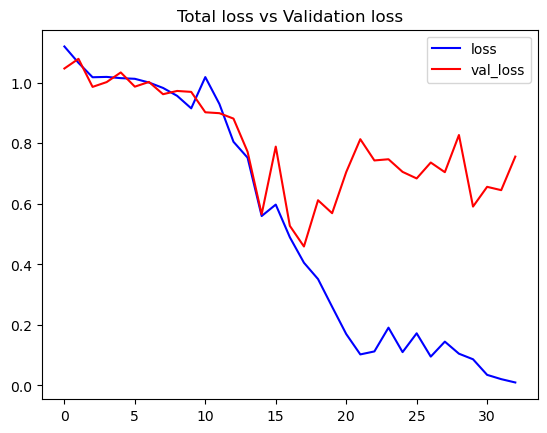

In [14]:
# Training data
plot_metrics(train_history, 'loss', 'val_loss', 'Total loss vs Validation loss')

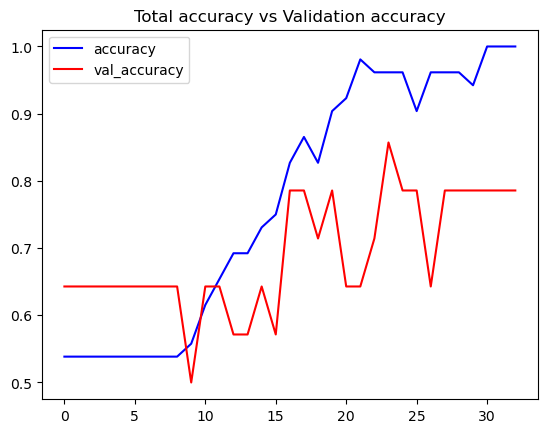

In [15]:
# Testingdata
plot_metrics(train_history, 'accuracy', 'val_accuracy', 'Total accuracy vs Validation accuracy')

In [16]:
if save_flag:
    ev_loss, ev_acc = eval_history
    model_filename = f'LRCN_Accuracy{ev_acc}.keras'
    model.save(model_filename)

In [17]:
def get_actual_predicted_labels(): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [label for label in label_test]
  predicted = model.predict(frame_test)

  actual = tf.stack(actual, axis=0)
  actual = tf.argmax(actual, axis=1)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [18]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels([0,1,2])
  ax.yaxis.set_ticklabels([0,1,2])

1/1 [==============================] - 2s 2s/step


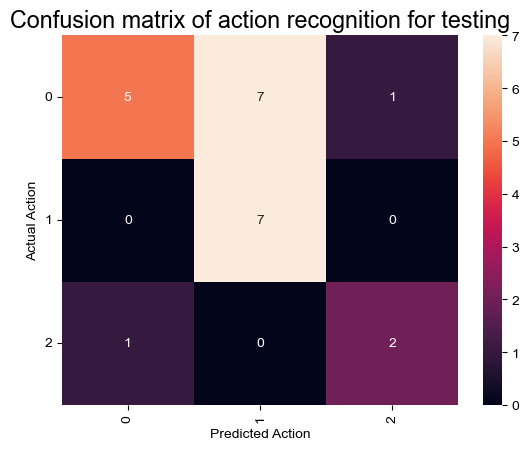

In [19]:
actual,pred = get_actual_predicted_labels()
plot_confusion_matrix(actual, pred, label_test, 'testing')

In [20]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [21]:
precision, recall = calculate_classification_metrics(actual, pred, [0,1,2]) # Test dataset

In [22]:
precision

{0: 0.8333333333333334, 1: 0.5, 2: 0.6666666666666666}

In [23]:
recall

{0: 0.38461538461538464, 1: 1.0, 2: 0.6666666666666666}